### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numerapi as nai
from zipfile import ZipFile
import re
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Data Loading

In [2]:
df = pd.read_csv('numerai_training_data.csv')

# Explore data attributes

In [3]:
df.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,feature_charisma27,feature_charisma28,feature_charisma29,feature_charisma30,feature_charisma31,feature_charisma32,feature_charisma33,feature_charisma34,feature_charisma35,...,feature_constitution112,feature_constitution113,feature_constitution114,feature_wisdom1,feature_wisdom2,feature_wisdom3,feature_wisdom4,feature_wisdom5,feature_wisdom6,feature_wisdom7,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,0.25,0.75,0.75,0.25,0.25,1.00,0.75,0.5,1.0,0.5,0.00,0.50,0.50,0.00,0.0,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.5,0.50,0.75,0.5,0.25,0.75,0.75,0.50,0.25,0.25,0.50,0.25,0.50,0.25,...,0.50,0.50,0.25,0.25,1.00,0.75,0.50,0.75,0.75,0.75,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.5,0.25,0.25,0.75,0.50,1.00,0.5,0.75,0.75,0.25,0.50,1.00,0.75,0.50,0.50,1.00,0.25,0.5,0.50,0.50,0.75,1.00,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,0.25,0.50,0.50,0.00,0.50,0.00,0.50,0.5,0.5,0.5,0.50,0.25,0.25,0.50,0.0,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.5,0.25,0.75,0.5,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.25,0.50,...,0.00,1.00,0.75,0.50,1.00,0.00,0.25,0.00,1.00,1.00,0.25,0.25,0.25,1.00,1.00,0.50,0.50,0.50,0.0,0.25,1.00,0.50,1.00,1.00,0.5,0.50,0.50,1.00,0.25,0.75,1.00,0.25,0.25,1.00,0.50,0.5,0.50,0.75,0.75,0.75,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,0.25,0.00,0.25,0.50,1.00,0.50,0.75,0.5,0.5,1.0,0.50,0.50,0.50,0.25,0.0,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.5,0.50,0.75,0.5,0.50,0.25,0.75,0.75,0.50,0.75,0.00,0.75,0.50,0.75,...,0.00,0.25,0.00,1.00,0.50,1.00,0.75,0.00,1.00,0.75,0.25,1.00,1.00,1.00,0.50,1.00,1.00,1.00,0.5,1.00,0.00,1.00,1.00,0.50,1.0,0.75,1.00,0.00,0.50,0.75,0.00,1.00,0.50,0.50,0.75,1.0,0.75,1.00,0.25,0.50,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,1.0,0.5,0.5,0.00,1.00,0.00,0.75,0.0,0.50,0.50,0.50,0.50,0.00,0.50,0.50,0.75,0.75,0.50,0.25,0.5,0.50,0.50,0.5,0.50,0.50,0.50,0.75,0.50,0.50,1.00,0.50,0.50,0.50,...,0.75,0.25,0.25,1.00,1.00,1.00,1.00,0.75,0.75,1.00,1.00,1.00,0.75,0.75,1.00,0.75,0.75,0.75,1.0,0.75,1.00,0.75,1.00,0.75,1.0,0.00,0.50,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.00,0.5,0.75,0.75,1.00,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,0.25,0.25,0.50,0.25,0.25,0.75,0.50,0.0,0.5,0.5,0.25,0.00,0.50,0.00,0.5,0.25,0.50,0.50,0.50,0.50,0.50,0.

In [4]:
df.shape

(501808, 314)

In [5]:
df.columns

Index(['id', 'era', 'data_type', 'feature_intelligence1',
       'feature_intelligence2', 'feature_intelligence3',
       'feature_intelligence4', 'feature_intelligence5',
       'feature_intelligence6', 'feature_intelligence7',
       ...
       'feature_wisdom38', 'feature_wisdom39', 'feature_wisdom40',
       'feature_wisdom41', 'feature_wisdom42', 'feature_wisdom43',
       'feature_wisdom44', 'feature_wisdom45', 'feature_wisdom46', 'target'],
      dtype='object', length=314)

### no NaN

In [6]:
df.isna().sum().sum()

0

### Check Eras

In [7]:
df['era'].nunique()

120

We can simplify the era thing by just keeping the era number and losing the redundant prefix

In [8]:
df['weeknum'] = df['era'].str.slice(3).astype(int)

#### Features consist of various prefixes

In [9]:
# naming convention can be condensed here a bit
features = set([re.split('\d', w)[0] for w in df.columns])

In [10]:
features

{'data_type',
 'era',
 'feature_charisma',
 'feature_constitution',
 'feature_dexterity',
 'feature_intelligence',
 'feature_strength',
 'feature_wisdom',
 'id',
 'target',
 'weeknum'}

#### id is unique and changes through each era

In [11]:
df['id'].nunique()

501808

In [12]:
df.shape

(501808, 315)

## Data Summary

In [13]:
def dataset_view(df, cat_feats=[]):
    """
    Return summary statistics of dataframe.
    This function prints data shape, number of features,
    duplicates, missing values(in percent and integer)
    zeros, uniques, and additional sample info. 
    
    Args:
    df - dataframe of information to summarize
    cat_feats - a list of features from the data frame which
    are categorical type
    """
    
    print(f"Number of Observations: {df.shape[0]}.\
    Number of Features: {df.shape[1]}. Number of Duplicates:\
    {np.sum(df.duplicated())}")
    df_report = pd.DataFrame({"Feature": df.columns})
    df_report["Type"] = df_report["Feature"].apply(lambda f: df[f].dtype)
    df_report["NA_Count"] = df_report["Feature"].apply(lambda f: np.sum(df[f].isna()))
    df_report["NA_Percentage"] = df_report["Feature"].apply(lambda f: np.round(np.sum(df[f].isna())*100/len(df[f]), 2))
    df_report["Zeros_Count"] = df_report["Feature"].apply(lambda f: np.sum(df[f] == 0))
    df_report["Zeros_Percentage"] = df_report["Feature"].apply(
        lambda f: np.round(np.sum(df[f] == 0)*100/len(df[f]), 2
                          ) if df[f].dtype in ['int', 'float'] else 0)
    df_report["Number_of_Unique"] = df_report["Feature"].apply(lambda f: df[f].nunique())
    df_report["Sample_Info"] = df_report["Feature"].apply(lambda f: feature_stats(df,f,cat_feats))
    return df_report

def feature_stats(df, f, cat_feats):
    """
    summary statistics function
    
    Based on args passed, will return certain
    summary statistics for a given dataset.
    
    df - the dataframe to use
    f - linker feature
    cat_feats - categorical features to consider
    
    returns summary statistics
    
    """
    if f in cat_feats:
        stats_dict = df[f].value_counts().head(2).to_dict()
    elif (df[f].dtype in ['int', 'float']) & (df[f].nunique() >= 30):
        stats_dict = {'min': np.round(df[f].min(),2),
                     'max': np.round(df[f].max(),2),
                     'mean': np.round(df[f].mean(),2),
                     'median': np.round(df[f].median(),2),
                     'std': np.round(df[f].std(),2)}
    else:
        stats_dict = df[f].value_counts().head(3).to_dict()
        
    return stats_dict

In [14]:
dataset_view(df)

Number of Observations: 501808.    Number of Features: 315. Number of Duplicates:    0


,Feature,Type,NA_Count,NA_Percentage,Zeros_Count,Zeros_Percentage,Number_of_Unique,Sample_Info
0,id,object,0,0.0,0,0.00,501808,"{'n000315175b67977': 1, 'n19b1b17e2834159': 1,..."
1,era,object,0,0.0,0,0.00,120,"{'era55': 4893, 'era58': 4893, 'era54': 4887}"
2,data_type,object,0,0.0,0,0.00,1,{'train': 501808}
3,feature_intelligence1,float64,0,0.0,100407,20.01,5,"{0.0: 100407, 1.0: 100388, 0.25: 100338}"
4,feature_intelligence2,float64,0,0.0,100406,20.01,5,"{0.0: 100406, 1.0: 100385, 0.5: 100343}"
...,...,...,...,...,...,...,...,...
310,feature_wisdom44,float64,0,0.0,99127,19.75,5,"{0.5: 105472, 0.0: 99127, 1.0: 99101}"
311,feature_wisdom45,float64,0,0.0,97081,19.35,5,"{0.5: 113637, 0.0: 97081, 1.0: 97060}"
312,feature_wisdom46,float64,0,0.0,100310,19.99,5,"{0.5: 100729, 0.0: 100310, 1.0: 100281}"
313,target,float64,0,0.0,25016,4.99,5,"{0.5: 251677, 0.25: 100053, 0.75: 100045}"


# Explore data relationships

The only temporal aspect of this data set is the sequential series `era`

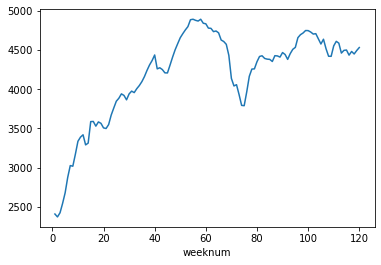

In [15]:
df.groupby('weeknum').size().plot();

## Target Distribution

Target is normally distributed over available eras

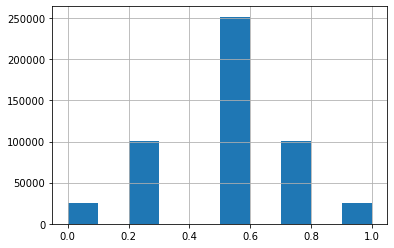

In [16]:
df['target'].hist();

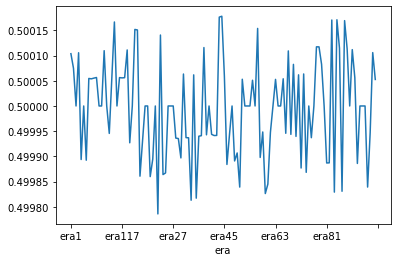

In [17]:
df.groupby('era')['target'].mean().plot();

## Target distribution over time

In [18]:
target_info = df[['era', 'target']]

In [19]:
target_info

,era,target
0,era1,0.50
1,era1,0.25
2,era1,0.25
3,era1,0.25
4,era1,0.75
...,...,...
501803,era120,0.50
501804,era120,0.75
501805,era120,0.25
501806,era120,0.50


In [20]:
target_info['target'] = target_info['target'].astype(str)

/var/folders/0c/xwdr9jns4t77j7flzxrd2bmr0000gn/T/ipykernel_4294/4221153828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_info['target'] = target_info['target'].astype(str)


In [21]:
targets = pd.get_dummies(target_info, columns=['target'])

In [22]:
targets.head()

,era,target_0.0,target_0.25,target_0.5,target_0.75,target_1.0
0,era1,0,0,1,0,0
1,era1,0,1,0,0,0
2,era1,0,1,0,0,0
3,era1,0,1,0,0,0
4,era1,0,0,0,1,0


In [23]:
target_info = targets.groupby('era').sum().reset_index()

In [24]:
target_info.head()

,era,target_0.0,target_0.25,target_0.5,target_0.75,target_1.0
0,era1,120.0,483.0,1202.0,482.0,121.0
1,era10,167.0,666.0,1669.0,667.0,167.0
2,era100,237.0,947.0,2380.0,947.0,237.0
3,era101,235.0,940.0,2378.0,942.0,235.0
4,era102,235.0,937.0,2361.0,937.0,234.0


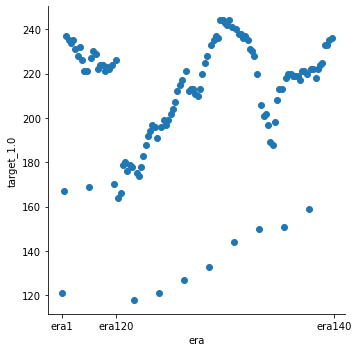

In [25]:
g = sns.FacetGrid(data=target_info, height=5)
g.map(plt.scatter, 'era', 'target_1.0')
x_ticks = ['era1', 'era120', 'era140']
g.set(xticks=x_ticks);

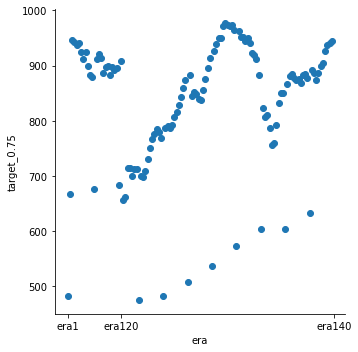

In [26]:
g = sns.FacetGrid(data=target_info, height=5)
g.map(plt.scatter, 'era', 'target_0.75')
x_ticks = ['era1', 'era120', 'era140']
g.set(xticks=x_ticks);

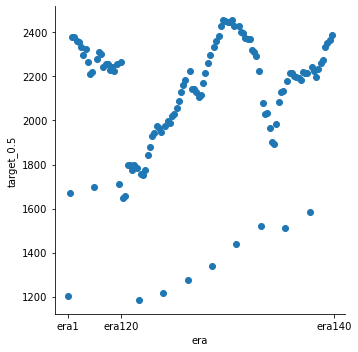

In [27]:
g = sns.FacetGrid(data=target_info, height=5)
g.map(plt.scatter, 'era', 'target_0.5')
x_ticks = ['era1', 'era120', 'era140']
g.set(xticks=x_ticks);

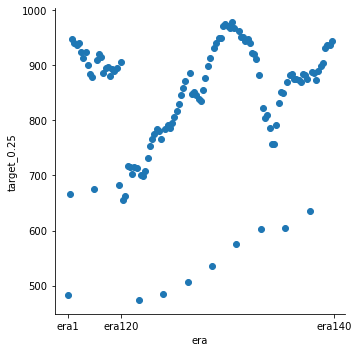

In [28]:
g = sns.FacetGrid(data=target_info, height=5)
g.map(plt.scatter, 'era', 'target_0.25')
x_ticks = ['era1', 'era120', 'era140']
g.set(xticks=x_ticks);

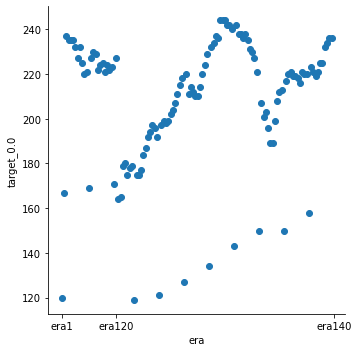

In [29]:
g = sns.FacetGrid(data=target_info, height=5)
g.map(plt.scatter, 'era', 'target_0.0')
x_ticks = ['era1', 'era120', 'era140']
g.set(xticks=x_ticks);

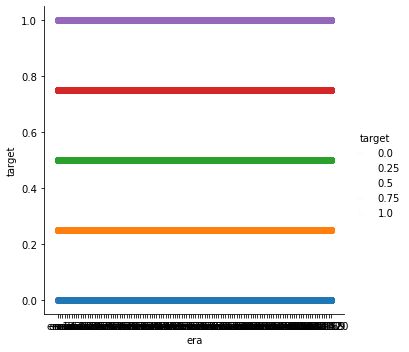

In [30]:
g = sns.FacetGrid(data = df, hue = 'target', height = 5)
g.map(plt.scatter, 'era', 'target', alpha=0.009)
g.add_legend();

## Intra-Feature correlations

In [31]:
features

{'data_type',
 'era',
 'feature_charisma',
 'feature_constitution',
 'feature_dexterity',
 'feature_intelligence',
 'feature_strength',
 'feature_wisdom',
 'id',
 'target',
 'weeknum'}

In [111]:
def sub_df(df, feature):
    """
    Create a sub dataframe with just features
    for whatever meta feature desired.
    
    args
    df - the dataframe to iterate through
    feature - the feature prefix to use as meta id

    returns dataframe subset
    """
    copy = df.copy()
    
    features = [f for f in df if feature in f]
    features.append('era')
    features.append('id')
    copy = copy[features]
    
    return copy

In [112]:
df_charisma = sub_df(df, 'feature_charisma')

In [113]:
df_charisma.head()

,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,feature_charisma27,feature_charisma28,feature_charisma29,feature_charisma30,feature_charisma31,feature_charisma32,feature_charisma33,feature_charisma34,feature_charisma35,feature_charisma36,feature_charisma37,feature_charisma38,feature_charisma39,feature_charisma40,feature_charisma41,feature_charisma42,feature_charisma43,feature_charisma44,feature_charisma45,feature_charisma46,feature_charisma47,feature_charisma48,feature_charisma49,feature_charisma50,feature_charisma51,feature_charisma52,feature_charisma53,feature_charisma54,feature_charisma55,feature_charisma56,feature_charisma57,feature_charisma58,feature_charisma59,feature_charisma60,feature_charisma61,feature_charisma62,feature_charisma63,feature_charisma64,feature_charisma65,feature_charisma66,feature_charisma67,feature_charisma68,feature_charisma69,feature_charisma70,feature_charisma71,feature_charisma72,feature_charisma73,feature_charisma74,feature_charisma75,feature_charisma76,feature_charisma77,feature_charisma78,feature_charisma79,feature_charisma80,feature_charisma81,feature_charisma82,feature_charisma83,feature_charisma84,feature_charisma85,feature_charisma86,era,id
0,1.00,0.75,0.5,1.0,0.5,0.00,0.50,0.50,0.00,0.0,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.5,0.50,0.75,0.5,0.25,0.75,0.75,0.50,0.25,0.25,0.50,0.25,0.50,0.25,0.75,0.25,0.25,0.50,0.50,0.75,0.25,0.50,0.25,0.50,0.25,0.5,0.50,0.50,0.25,0.50,0.25,0.75,0.00,0.25,0.5,0.00,0.00,0.75,0.5,0.50,0.25,0.50,0.50,0.5,0.25,0.25,0.25,0.00,0.5,0.50,0.5,0.50,0.00,0.50,0.50,0.75,0.00,0.50,0.75,0.50,0.50,0.0,0.75,0.50,0.50,era1,n000315175b67977
1,0.00,0.50,0.5,0.5,0.5,0.50,0.25,0.25,0.50,0.0,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.5,0.25,0.75,0.5,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.25,0.50,0.75,0.75,0.50,0.50,0.50,0.50,0.50,0.00,0.25,0.25,0.00,0.5,0.25,0.50,0.50,0.75,0.50,1.00,0.50,0.00,0.5,1.00,1.00,0.50,0.5,0.50,0.50,0.25,0.50,0.5,0.00,0.50,0.50,0.75,0.0,0.50,0.0,0.50,0.25,0.50,1.00,0.50,0.00,0.50,0.50,1.00,0.75,1.0,0.50,0.25,0.50,era1,n0014af834a96cdd
2,0.50,0.75,0.5,0.5,1.0,0.50,0.50,0.50,0.25,0.0,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.5,0.50,0.75,0.5,0.50,0.25,0.75,0.75,0.50,0.75,0.00,0.75,0.50,0.75,0.25,0.25,0.75,0.50,0.50,0.75,0.75,0.50,1.00,0.50,0.75,0.5,0.00,0.75,0.75,0.75,0.75,0.75,0.25,0.50,0.5,0.00,0.00,1.00,0.5,0.50,0.75,0.50,0.75,0.5,0.50,0.50,0.75,0.25,0.5,0.50,0.5,0.75,0.75,0.75,0.25,0.00,0.00,0.75,0.75,0.25,0.75,0.0,0.50,0.50,0.75,era1,n001c93979ac41d4
3,0.75,0.50,1.0,0.5,0.5,0.00,1.00,0.00,0.75,0.0,0.50,0.50,0.50,0.50,0.00,0.50,0.50,0.75,0.75,0.50,0.25,0.5,0.50,0.50,0.5,0.50,0.50,0.50,0.75,0.50,0.50,1.00,0.50,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.50,0.50,0.25,0.25,1.00,0.00,0.5,1.00,0.50,0.50,0.50,0.50,0.50,0.00,0.50,0.5,1.00,0.75,0.50,0.5,0.75,0.50,1.00,0.50,0.5,0.00,0.50,0.25,0.75,0.5,0.75,0.5,0.50,0.50,0.50,0.75,0.50,0.00,0.50,0.50,0.75,0.50,1.0,0.50,0.75,0.50,era1,n0034e4143f22a13
4,0.75,0.50,0.0,0.5,0.5,0.25,0.00,0.50,0.00,0.5,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.50,0.25,0.5,0.50,0.50,0.5,0.25,0.50,0.25,0.00,0.50,0.75,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.25,0.25,0.50,0.50,0.25,0.00,0.00,1.00,0.5,0.25,0.50,0.50,0.75,0.00,0.50,0.25,0.50,0.5,0.25,0.50,0.50,0.5,0.50,0.00,0.75,0.50,0.5,1.00,0.00,0.50,0.00,0.5,0.00,0.0,0.50,0.25,0.50,0.50,0.50,0.25,0.50,0.50,0.75,0.50,0.5,0.50,0.75,0.50,era1,n00679d1a636062f


In [114]:
df_charisma.corr().stack().head()

feature_charisma1  feature_charisma1    1.000000
                   feature_charisma2    0.058545
                   feature_charisma3    0.057526
                   feature_charisma4    0.025643
                   feature_charisma5   -0.001631
dtype: float64

In [115]:
for feat in features:
    x = sub_df(df, feat)
    print(x.corr().stack().head())

Series([], dtype: float64)
feature_charisma1  feature_charisma1    1.000000
                   feature_charisma2    0.058545
                   feature_charisma3    0.057526
                   feature_charisma4    0.025643
                   feature_charisma5   -0.001631
dtype: float64
Series([], dtype: float64)
feature_wisdom1  feature_wisdom1    1.000000
                 feature_wisdom2    0.265080
                 feature_wisdom3    0.037083
                 feature_wisdom4    0.120331
                 feature_wisdom5    0.150657
dtype: float64
feature_intelligence1  feature_intelligence1    1.000000
                       feature_intelligence2   -0.014157
                       feature_intelligence3   -0.024404
                       feature_intelligence4    0.652596
                       feature_intelligence5    0.069868
dtype: float64
feature_constitution1  feature_constitution1    1.000000
                       feature_constitution2    0.005346
                       feature_c

In [132]:
df[['feature_intelligence1', 'target']]

,feature_intelligence1,target
0,0.00,0.50
1,0.00,0.25
2,0.25,0.25
3,1.00,0.25
4,0.25,0.75
...,...,...
501803,0.50,0.50
501804,1.00,0.75
501805,0.75,0.25
501806,0.25,0.50


In [129]:
def feat_targ_corr(df, feature):
    fig, ax = plt.subplots(figsize=(12, 12))
    sub = df[[feature, 'target']]
    sns.heatmap(sub.corr(), ax = ax)

In [136]:
featz = [n for n in df.columns if 'feature' in n]

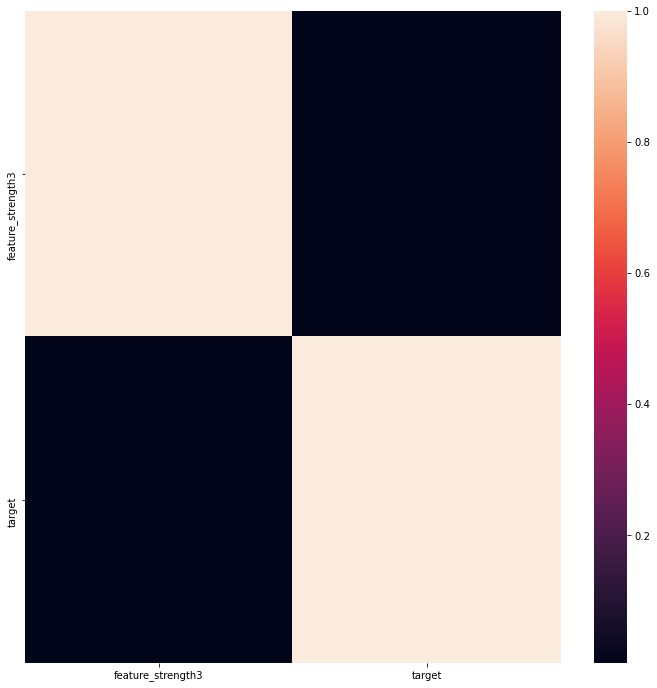

In [140]:
feat_targ_corr(df, featz[100])

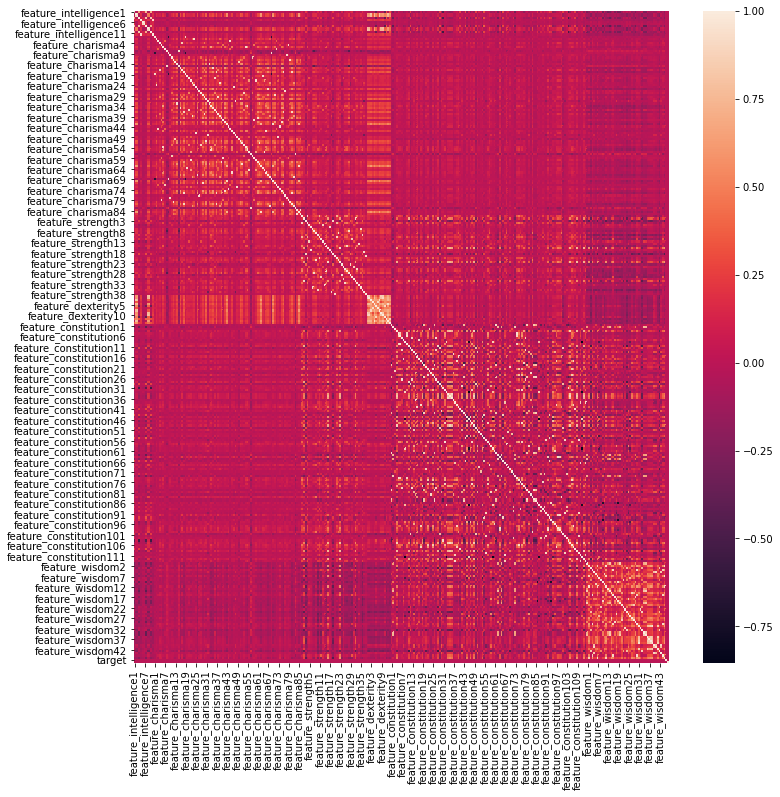

In [128]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(df.corr(), ax = ax);

# Create Data Cleaning Function

As we find things to clean and fix, we will add to this function to create a complete data wrangler.

In [ ]:
def clean_data(df):
    """
    cleans and prepares dataframe for modelling
    
    args:
    df - dataframe to be processed
    
    returns:
    train/test splitted data sets ready for modelling
    
    """
    clean_df = df.copy()
    featnames = [f for f in df if f.startswith("feature")]
    X = clean_df[featnames]
    y = clean_df['target']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.3)
        
    return X_train, X_test, y_train, y_test